# This code replicates original SINDy as well as variants with different methods of optimization

Structure:
- Original SINDy Implementation
- Original LASSO Regression
- Base Proximal Optimization Algorithm
- SR3 Algorithm
- SR3 Applied to SINDy

/Users/brianwodetzki/School/ME697ML/final_project/.venv/lib/python3.11/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: The following arguments have no effect for a chosen solver: `reltol`, `abstol`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


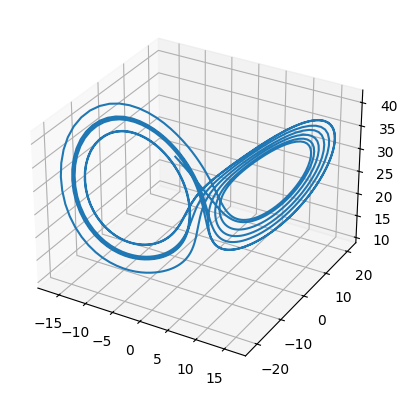

In [1]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import data_generator as dg

t, bigX, dX = dg.solve_lorenz_sys(10)
x, y, z = bigX.T
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot(x, y, z)

In [2]:
bigX

Array([[-8.        ,  7.        , 27.        ],
       [-6.5797257 ,  6.814741  , 25.792149  ],
       [-5.3146987 ,  6.584993  , 24.719727  ],
       ...,
       [ 0.32762256,  1.4643061 , 19.790844  ],
       [ 0.43662563,  1.4820915 , 19.275145  ],
       [ 0.5374892 ,  1.51101   , 18.774614  ]], dtype=float32)

In [3]:
from feature_maker import polynomial_features
features, feature_list, feature_name = polynomial_features(state_dim=3, order=3)
Phi = features(bigX)
Phi.shape

(1000, 20)

In [4]:
from regression_algs import vanilla_SINDy

fit = vanilla_SINDy(Phi, dX, prox_w=0.025, eps=1e-8)

In [16]:
import numpy as np
import sympy as sy

def get_functions(fit, feature_name, disp=True):
    t = sy.Symbol('t')
    vars = [sy.Function(f'x{i}')(t) for i in range(fit.shape[1])]
    eqs = np.einsum('i, ij -> ij', feature_name, fit)
    eq_list = np.sum(eqs, axis=0)
    eq_list = [sy.Eq(sy.diff(vars[i], t), eq_list[i]) for i in range(fit.shape[1])]
    if disp:
        sy.init_printing(use_latex='mathjax')
        for eq in eq_list:
            display(eq)

    return eq_list

eq_list = get_functions(fit, feature_name)

d                                                                             
──(x₀(t)) = -0.0812486335635185⋅x₀⋅x₂ + 1.47870171070099⋅x₀ + 1.53428399562836
dt                                                                            

                                             
⋅x₁ - 0.0683040842413902⋅x₂ + 2.0926570892334
                                             

d                                                                             
──(x₁(t)) = -0.129565834999084⋅x₀⋅x₂ + 1.95441722869873⋅x₀ - 0.075124658644199
dt                                                                            

                                                                         
4⋅x₁⋅x₂ + 2.40356707572937⋅x₁ - 0.0301042906939983⋅x₂ + 0.763342559337616
                                                                         

d                                                                             
──(x₂(t)) = 0.18395359814167⋅x₀⋅x₁ + 0.123574435710907⋅x₀ + 0.0782397985458374
dt                                                                            

   2                                                                 
⋅x₁  - 0.298050701618195⋅x₁ - 0.539445757865906⋅x₂ - 12.2508316040039
                                                                     

In [6]:
# Get list of state functions
from feature_maker import get_integrator

integrator = get_integrator(fit, feature_list)

Text(0.5, 0, '$\\sigma$')

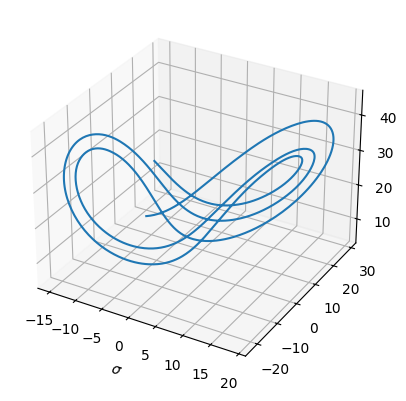

In [14]:
from scipy.integrate import solve_ivp

sol = solve_ivp(integrator, [0, 10], [-8.0, 7.0, 27.0], t_eval=np.linspace(0, 10, 1000))
x, y, z = sol.y

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot(x, y, z)
plt.xlabel("$\sigma$")

Now, lets analyze how noise effects the system:

  0%|          | 0/100 [00:00<?, ?it/s]/Users/brianwodetzki/School/ME697ML/final_project/.venv/lib/python3.11/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: The following arguments have no effect for a chosen solver: `reltol`, `abstol`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)
100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Text(0, 0.5, 'Absolute Error')

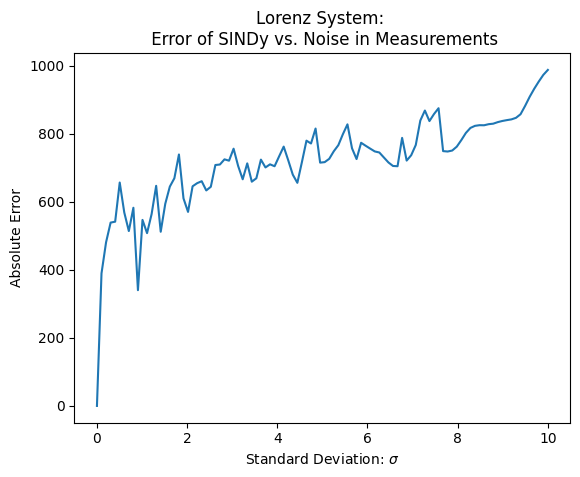

In [15]:
from regression_algs import SINDy_CV
from tqdm import tqdm
key = jax.random.PRNGKey(0)
errors = []
sigmas = np.linspace(0, 10, 100)
for sigma in tqdm(sigmas):
    # Simulate dynamics
    t, bigX, dX = dg.solve_lorenz_sys(10, noise_sigma=sigma, seed=0)
    # Predict
    # key, subkey = jax.random.split(key)
    # fit, _, _ = SINDy_CV(bigX, dX, features, subkey)
    Phi = features(bigX)
    fit = vanilla_SINDy(Phi, dX, prox_w=0.025, eps=1e-8)
    # Get dynamics
    integrator = get_integrator(fit, feature_list)
    # Integrate
    sol = solve_ivp(integrator, [0, 10], [-8.0, 7.0, 27.0], t_eval=np.linspace(0, 10, 1000))

    error = jnp.linalg.norm(bigX - sol.y.T)
    errors.append(error)

plt.plot(sigmas, errors)  
plt.title("Lorenz System: \n Error of SINDy vs. Noise in Measurements")
plt.xlabel("Standard Deviation: $\sigma$")
plt.ylabel("Absolute Error")